# Titanic - Machine Learning from Disasters
## Kaggle Competition

#### RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early hours of 15 April 1912, after colliding with an iceberg during her maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. RMS Titanic was the largest ship afloat at the time she entered service and was the second of three Olympic-class ocean liners operated by the White Star Line.

### In this exercise, we will try to predict whether a passenger on the Titanic would have survived or not.

### Import the necessary libraries

In [113]:
# Import our libraries
import pandas as pd
import numpy as np

# Import sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc, make_scorer, confusion_matrix, f1_score, fbeta_score

# Import the Naive Bayes, logistic regression, Bagging, RandomForest, AdaBoost, GradientBoost, Decision Trees and SVM Classifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib import style
#plt.style.use('bmh')
#plt.style.use('ggplot')
plt.style.use('seaborn-notebook')

from matplotlib.ticker import StrMethodFormatter

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer


### Read the training and testing data

In [114]:
#titanic_features = pd.read_csv('train.csv')
test_df = pd.read_csv("data/test.csv")
train_df = pd.read_csv("data/train.csv")

### Exploratory Analysis

In [115]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [116]:
train_df.shape

(891, 12)

In [9]:
test_df.shape

(418, 11)

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [11]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Features:
* `survival`: Survival 
* `PassengerId`: Unique Id of a passenger
* `pclass`: Ticket class     
* `sex`: Sex     
* `Age`: Age in years     
* `sibsp`: # of siblings / spouses aboard the Titanic     
* `parch`: # of parents / children aboard the Titanic     
* `ticket`: Ticket number     
* `fare`: Passenger fare     
* `cabin`: Cabin number     
* `embarked`: Port of Embarkation

In [12]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### From the table above, we can note a few things:
* ##### We have a few categorical variabes that need to be either converted to numerical or one-hot encoded, so that the machine learning algorithms can process them. 
* ##### The features have widely different ranges, and we will need to convert into roughly the same scale. 
* ##### Some features contain missing values (NaN = not a number), that we need to deal with.

### Missing data 

`Age` and `Embarked`

In [14]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


##### The `Embarked` feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the `Age` feature, which has 177 missing values. The `Cabin` feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.

In [16]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

#### Suppress warnings from output

In [17]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

### Q1: How many people Embarked from different ports? Is there a correlation between port of embarkment and survival? 

In [18]:
train_df['Embarked'].value_counts()/len(train_df)

S    0.722783
C    0.188552
Q    0.086420
Name: Embarked, dtype: float64

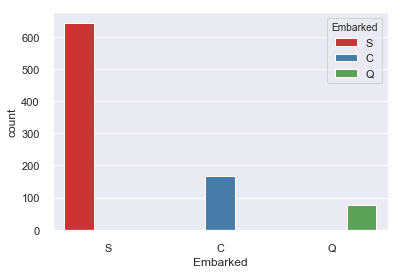

In [19]:
sns.set(style="darkgrid")
sns.countplot( x='Embarked', data=train_df, hue="Embarked", palette="Set1");

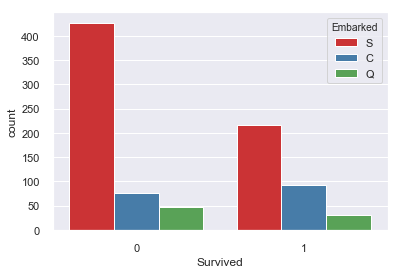

In [21]:
sns.set(style="darkgrid")
sns.countplot( x='Survived', data=train_df, hue="Embarked", palette="Set1");

In [22]:
train_df.groupby('Embarked').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


### Q2: Does survival depend upon gender?

In [23]:
train_df.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


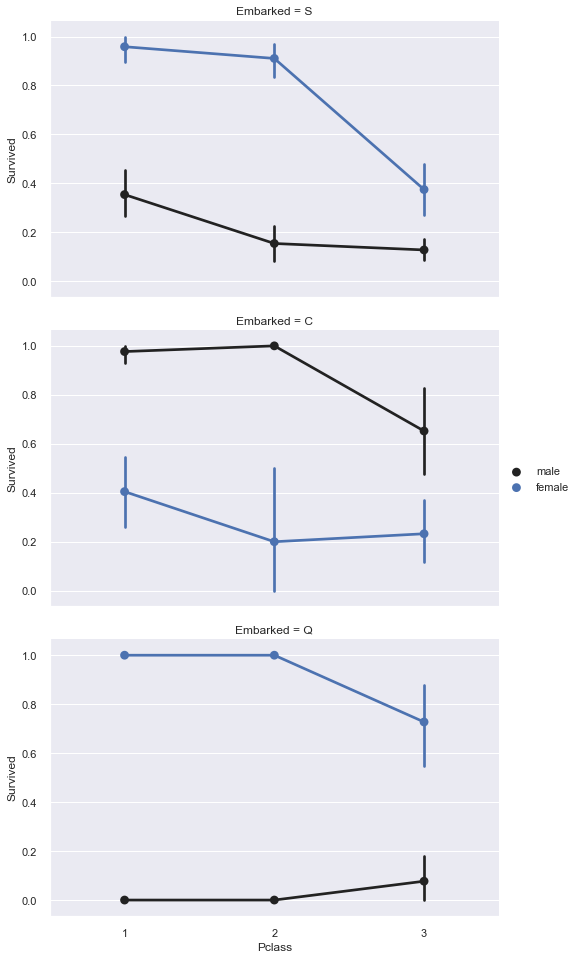

In [24]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None )
FacetGrid.add_legend();

* ##### Embarked seems to be correlated with survival, depending on the gender.

* ##### Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S.

* ##### Pclass also seems to be correlated with survival. We will generate another plot of it below.

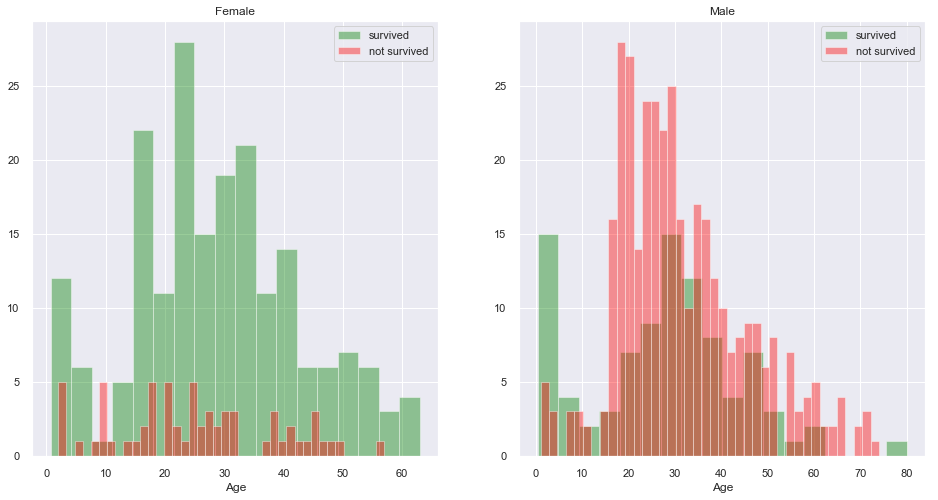

In [25]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False, color="green")
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False, color="green")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend()
_ = ax.set_title('Male');

* ##### You can see that men have a high probability of survival when they are between 18 and 30 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 14 and 40.

* ##### For men the probability of survival is very low between the age of 5 and 18, but that isn’t true for women. Another thing to note is that infants also have a little bit higher probability of survival.

* ##### Since there seem to be certain ages, which have increased odds of survival and because I want every feature to be roughly on the same scale, I will create age groups later on.

#### Pclass

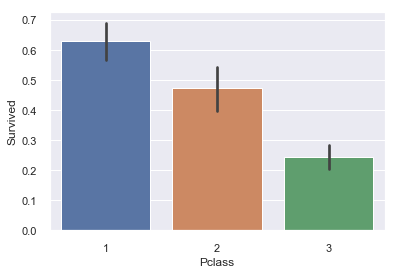

In [26]:
sns.barplot(x='Pclass', y='Survived', data=train_df);

##### Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1. We will create another pclass plot below.

/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


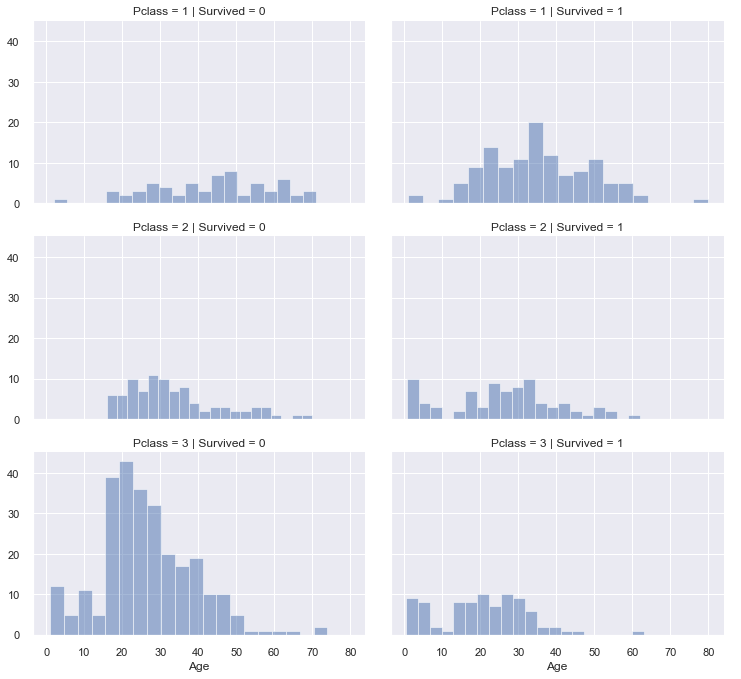

In [27]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=3.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

##### The plot above confirms our assumption about pclass 1, but we can also spot a high probability that a person in pclass 3 will not survive.

#### `SibSp` and `Parch`

##### SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic. I will create it below and also a feature that sows if someone is not alone.

In [28]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'travelled_alone'] = 'No'
    dataset.loc[dataset['relatives'] == 0, 'travelled_alone'] = 'Yes'
    #dataset['travelled_alone'] = dataset['travelled_alone'].astype(int)
train_df['travelled_alone'].value_counts()

Yes    537
No     354
Name: travelled_alone, dtype: int64

In [29]:
test_df['travelled_alone'].value_counts()

Yes    253
No     165
Name: travelled_alone, dtype: int64

In [30]:
train_df['relatives'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: relatives, dtype: int64

### Q3: Do the passengers have better chance at survival while travelling alone?

/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


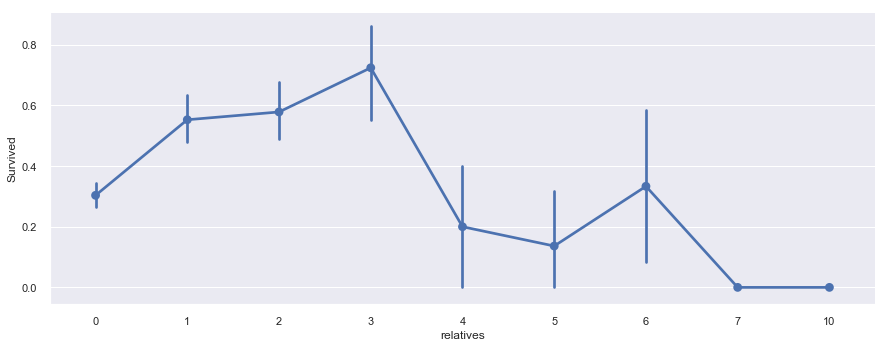

In [31]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, );

##### Here we can see that you had a high probabilty of survival with 1 to 3 realitves, but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

### Data Preprocessing

In [32]:
# Drop 'PassengerId' from the train set, because it does not contribute to a persons survival probability.
train_df = train_df.drop(['PassengerId'], axis=1)

#### Missing Data

#### Cabin:
##### Cabin number looks like ‘C23’ and the letter refers to the deck. We will extract these and create a new feature, to represent a persons deck. 

In [33]:
train_df['Cabin'].describe()

count     204
unique    147
top        G6
freq        4
Name: Cabin, dtype: object

In [34]:
import re
deck = {"A": "A", "B": "B", "C": "C", "D": "D", "E": "E", "F": "F", "G": "G", "U": "U"}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna("U")
    #dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [35]:
train_df['Deck'].value_counts()

U    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Deck, dtype: int64

In [36]:
train_df.groupby('Deck').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,relatives
Deck,,,,,,,
A,0.466667,1.000000,44.833333,0.133333,0.133333,39.623887,0.266667
B,0.744681,1.000000,34.955556,0.361702,0.574468,113.505764,0.936170
C,0.593220,1.000000,36.086667,0.644068,0.474576,100.151341,1.118644
D,0.757576,1.121212,39.032258,0.424242,0.303030,57.244576,0.727273
E,0.750000,1.312500,38.116667,0.312500,0.312500,46.026694,0.625000
F,0.615385,2.384615,19.954545,0.538462,0.538462,18.696792,1.076923
G,0.500000,3.000000,14.750000,0.500000,1.250000,13.581250,1.750000
U,0.299419,2.636628,27.588208,0.546512,0.364826,19.181079,0.911337


In [37]:
test_df['Deck'].value_counts()

U    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Deck, dtype: int64

#### Age:
##### Fill null values with random numbers, which are computed based on the mean age value in regards to the standard deviation.

In [38]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)

In [39]:
train_df["Age"].isnull().sum()

0

In [40]:
test_df["Age"].isnull().sum()

0

In [41]:
train_df["Age"].describe()

count    891.000000
mean      29.526375
std       13.490410
min        0.000000
25%       21.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [42]:
#train_df.groupby('Age').mean()

#### Embarked:

In [43]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [44]:
train_df['Embarked'].mode()

0    S
dtype: object

In [45]:
#common_value = train_df['Embarked'].mode()
#common_value

In [46]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [47]:
test_df['Embarked'].describe()

count     418
unique      3
top         S
freq      270
Name: Embarked, dtype: object

### Converting Features

#### Fare: Convert from float to int

In [48]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [117]:
train_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [50]:
train_df['Fare'].isnull().sum()

0

In [51]:
test_df['Fare'].describe()

count    418.000000
mean      35.100478
std       55.872752
min        0.000000
25%        7.000000
50%       14.000000
75%       31.000000
max      512.000000
Name: Fare, dtype: float64

In [52]:
test_df['Fare'].isnull().sum()

0

In [53]:
train_df['Fare'] = train_df['Fare'].astype(int)

In [54]:
test_df['Fare'] = test_df['Fare'].astype(int)

#### Name: Extract titles from name and build a new feature from that

In [55]:
train_titles = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
type(train_titles)

pandas.core.series.Series

In [56]:
train_titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Don           1
Ms            1
Lady          1
Sir           1
Mme           1
Jonkheer      1
Capt          1
Name: Name, dtype: int64

In [57]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    #dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna("NA")
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [58]:
train_df.groupby(['Title']).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,relatives
Title,,,,,,,
Master,0.575000,2.625000,7.425000,2.300000,1.375000,34.250000,3.675000
Miss,0.702703,2.291892,22.962162,0.702703,0.540541,43.340541,1.243243
Mr,0.156673,2.410058,31.510638,0.288201,0.152805,24.021277,0.441006
Mrs,0.793651,1.992063,35.158730,0.690476,0.825397,44.984127,1.515873
Rare,0.347826,1.347826,45.304348,0.347826,0.086957,36.782609,0.434783


In [59]:
test_df.groupby(['Title']).mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,relatives
Title,,,,,,,
Master,1123.380952,2.714286,28.809524,1.571429,1.380952,38.142857,2.952381
Miss,1100.240506,2.443038,28.835443,0.544304,0.392405,39.139241,0.936709
Mr,1101.279167,2.320833,28.595833,0.270833,0.175000,25.016667,0.445833
Mrs,1090.097222,1.833333,29.916667,0.597222,0.833333,59.611111,1.430556
Rare,1117.500000,1.333333,27.500000,0.500000,0.333333,80.500000,0.833333


#### Sex: Convert to numeric

In [60]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [61]:
'''
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

'''

'\ngenders = {"male": 0, "female": 1}\ndata = [train_df, test_df]\n\nfor dataset in data:\n    dataset[\'Sex\'] = dataset[\'Sex\'].map(genders)\n\n'

#### Ticket:

In [62]:
train_df['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [63]:
test_df['Ticket'].describe()

count          418
unique         363
top       PC 17608
freq             5
Name: Ticket, dtype: object

##### Since the Ticket attribute has too many unique values, it will be a bit tricky to convert them into useful categories. So we will drop it from the dataset.

In [64]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

#### Embarked: Convert to Numeric

In [65]:
'''
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)
    
'''    

'\nports = {"S": 0, "C": 1, "Q": 2}\ndata = [train_df, test_df]\n\nfor dataset in data:\n    dataset[\'Embarked\'] = dataset[\'Embarked\'].map(ports)\n    \n'

### Create new features

#### Age times class

In [66]:

data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']
    
    

#### Fare per Person:

In [67]:

for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
    

### Creating categories:

#### Age: Convert from float to int and create a new feature "AgeGroup" using bins 

In [68]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 7
    
    dataset['Age'] = dataset['Age'].astype(str)
    dataset.loc[ dataset['Age'] == '0', 'Age'] = "Children"
    dataset.loc[ dataset['Age'] == '1', 'Age'] = "Teens"
    dataset.loc[ dataset['Age'] == '2', 'Age'] = "Youngsters"
    dataset.loc[ dataset['Age'] == '3', 'Age'] = "Young Adults"
    dataset.loc[ dataset['Age'] == '4', 'Age'] = "Adults"
    dataset.loc[ dataset['Age'] == '5', 'Age'] = "Middle Age"
    dataset.loc[ dataset['Age'] == '6', 'Age'] = "Senior"
    dataset.loc[ dataset['Age'] == '7', 'Age'] = "Retired"

# let's see how it's distributed 
train_df['Age'].value_counts()

Adults          158
Senior          154
Middle Age      152
Young Adults    145
Youngsters      115
Teens            92
Children         68
Retired           7
Name: Age, dtype: int64

In [69]:
test_df['Age'].value_counts()

Middle Age      78
Adults          70
Young Adults    69
Senior          65
Youngsters      60
Teens           41
Children        33
Retired          2
Name: Age, dtype: int64

In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived           891 non-null int64
Pclass             891 non-null int64
Sex                891 non-null object
Age                891 non-null object
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null int64
Embarked           891 non-null object
relatives          891 non-null int64
travelled_alone    891 non-null object
Deck               891 non-null object
Title              891 non-null object
Age_Class          891 non-null int64
Fare_Per_Person    891 non-null int64
dtypes: int64(8), object(6)
memory usage: 97.5+ KB


#### Fare:

In [71]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset['Fare'] = dataset['Fare'].astype(str)
    dataset.loc[ dataset['Fare'] == '0', 'Fare'] = "Extremely Low"
    dataset.loc[ dataset['Fare'] == '1', 'Fare'] = "Very Low"
    dataset.loc[ dataset['Fare'] == '2', 'Fare'] = "Low"
    dataset.loc[ dataset['Fare'] == '3', 'Fare'] = "High"
    dataset.loc[ dataset['Fare'] == '4', 'Fare'] = "Very High"
    dataset.loc[ dataset['Fare'] == '5', 'Fare'] = "Extremely High"
    

In [72]:
train_df['Fare'].value_counts()

Extremely Low     241
Low               223
Very Low          216
High              158
Very High          44
Extremely High      9
Name: Fare, dtype: int64

In [73]:
test_df['Fare'].value_counts()

Extremely Low     120
Low               102
Very Low           96
High               69
Very High          23
Extremely High      8
Name: Fare, dtype: int64

In [74]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived           891 non-null int64
Pclass             891 non-null int64
Sex                891 non-null object
Age                891 non-null object
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null object
Embarked           891 non-null object
relatives          891 non-null int64
travelled_alone    891 non-null object
Deck               891 non-null object
Title              891 non-null object
Age_Class          891 non-null int64
Fare_Per_Person    891 non-null int64
dtypes: int64(7), object(7)
memory usage: 97.5+ KB


In [75]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId        418 non-null int64
Pclass             418 non-null int64
Sex                418 non-null object
Age                418 non-null object
SibSp              418 non-null int64
Parch              418 non-null int64
Fare               418 non-null object
Embarked           418 non-null object
relatives          418 non-null int64
travelled_alone    418 non-null object
Deck               418 non-null object
Title              418 non-null object
Age_Class          418 non-null int64
Fare_Per_Person    418 non-null int64
dtypes: int64(7), object(7)
memory usage: 45.8+ KB


In [76]:
# Let's take a last look at the training set
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,travelled_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,male,Youngsters,1,0,Extremely Low,S,1,No,U,Mr,66,3
1,1,1,female,Middle Age,1,0,High,C,1,No,C,Mrs,38,35
2,1,3,female,Young Adults,0,0,Extremely Low,S,0,Yes,U,Miss,78,7
3,1,1,female,Middle Age,1,0,High,S,1,No,C,Mrs,35,26
4,0,3,male,Middle Age,0,0,Very Low,S,0,Yes,U,Mr,105,8
5,0,3,male,Young Adults,0,0,Very Low,Q,0,Yes,U,Mr,78,8
6,0,1,male,Senior,0,0,High,S,0,Yes,E,Mr,54,51
7,0,3,male,Children,3,1,Low,S,4,No,U,Master,6,4
8,1,3,female,Young Adults,0,2,Very Low,S,2,No,U,Mrs,81,3
9,1,2,female,Teens,1,0,Low,C,1,No,U,Mrs,28,15


In [77]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived           891 non-null int64
Pclass             891 non-null int64
Sex                891 non-null object
Age                891 non-null object
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null object
Embarked           891 non-null object
relatives          891 non-null int64
travelled_alone    891 non-null object
Deck               891 non-null object
Title              891 non-null object
Age_Class          891 non-null int64
Fare_Per_Person    891 non-null int64
dtypes: int64(7), object(7)
memory usage: 97.5+ KB


In [78]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId        418 non-null int64
Pclass             418 non-null int64
Sex                418 non-null object
Age                418 non-null object
SibSp              418 non-null int64
Parch              418 non-null int64
Fare               418 non-null object
Embarked           418 non-null object
relatives          418 non-null int64
travelled_alone    418 non-null object
Deck               418 non-null object
Title              418 non-null object
Age_Class          418 non-null int64
Fare_Per_Person    418 non-null int64
dtypes: int64(7), object(7)
memory usage: 45.8+ KB


In [79]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [80]:
data = [train_df, test_df]

for dataset in data:
    dataset['Pclass'] = dataset['Pclass'].astype(str)
    dataset.loc[ dataset['Pclass'] == '1', 'Pclass'] = "Class1"
    dataset.loc[ dataset['Pclass'] == '2', 'Pclass'] = "Class2"
    dataset.loc[ dataset['Pclass'] == '3', 'Pclass'] = "Class3"
    

In [81]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived           891 non-null int64
Pclass             891 non-null object
Sex                891 non-null object
Age                891 non-null object
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null object
Embarked           891 non-null object
relatives          891 non-null int64
travelled_alone    891 non-null object
Deck               891 non-null object
Title              891 non-null object
Age_Class          891 non-null int64
Fare_Per_Person    891 non-null int64
dtypes: int64(6), object(8)
memory usage: 97.5+ KB


In [82]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId        418 non-null int64
Pclass             418 non-null object
Sex                418 non-null object
Age                418 non-null object
SibSp              418 non-null int64
Parch              418 non-null int64
Fare               418 non-null object
Embarked           418 non-null object
relatives          418 non-null int64
travelled_alone    418 non-null object
Deck               418 non-null object
Title              418 non-null object
Age_Class          418 non-null int64
Fare_Per_Person    418 non-null int64
dtypes: int64(6), object(8)
memory usage: 45.8+ KB


In [83]:
train_df['Pclass'].value_counts()

Class3    491
Class1    216
Class2    184
Name: Pclass, dtype: int64

## Scaling the numerical data

In [84]:
# Capture all the numerical features so that we can scale them later
#data = [train_df, test_df]
train_numerical_features = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_numerical_features

['Survived', 'SibSp', 'Parch', 'relatives', 'Age_Class', 'Fare_Per_Person']

In [85]:
type(train_numerical_features)

list

In [86]:
del train_numerical_features[0]
train_numerical_features

['SibSp', 'Parch', 'relatives', 'Age_Class', 'Fare_Per_Person']

In [87]:
# Feature scaling - Standard scaler
ss_scaler = StandardScaler()
train_df_ss = pd.DataFrame(data = train_df)
train_df_ss[train_numerical_features] = ss_scaler.fit_transform(train_df_ss[train_numerical_features])

/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [88]:
train_df_ss.shape

(891, 14)

In [89]:
train_df_ss.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,travelled_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,Class3,male,Youngsters,0.432793,-0.473674,Extremely Low,S,0.059160,No,U,Mr,0.043915,-0.459218
1,1,Class1,female,Middle Age,0.432793,-0.473674,High,C,0.059160,No,C,Mrs,-0.779217,0.434090
2,1,Class3,female,Young Adults,-0.474545,-0.473674,Extremely Low,S,-0.560975,Yes,U,Miss,0.396686,-0.347554
3,1,Class1,female,Middle Age,0.432793,-0.473674,High,S,0.059160,No,C,Mrs,-0.867410,0.182847
4,0,Class3,male,Middle Age,-0.474545,-0.473674,Very Low,S,-0.560975,Yes,U,Mr,1.190420,-0.319638


In [90]:
test_numerical_features = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_numerical_features

['PassengerId', 'SibSp', 'Parch', 'relatives', 'Age_Class', 'Fare_Per_Person']

In [91]:
del test_numerical_features[0]
test_numerical_features

['SibSp', 'Parch', 'relatives', 'Age_Class', 'Fare_Per_Person']

In [92]:
# Feature scaling - Standard scaler
test_ss_scaler = StandardScaler()
test_df_ss = pd.DataFrame(data = test_df)
test_df_ss[test_numerical_features] = test_ss_scaler.fit_transform(test_df_ss[test_numerical_features])

/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [93]:
test_df.shape

(418, 14)

In [94]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,travelled_alone,Deck,Title,Age_Class,Fare_Per_Person
0,892,Class3,male,Youngsters,-0.499470,-0.400248,Extremely Low,Q,-0.553443,Yes,U,Mr,0.003218,-0.401204
1,893,Class3,female,Middle Age,0.616992,-0.400248,Extremely Low,S,0.105643,No,U,Mrs,1.198866,-0.513662
2,894,Class2,male,Young Adults,-0.499470,-0.400248,Very Low,Q,-0.553443,Yes,U,Mr,-0.345513,-0.344975
3,895,Class3,male,Middle Age,-0.499470,-0.400248,Very Low,S,-0.553443,Yes,U,Mr,0.974682,-0.373089
4,896,Class3,female,Middle Age,0.616992,0.619896,Very Low,S,0.764728,No,U,Mrs,0.974682,-0.485547


## One-hot encoding

In [95]:
# One-Hot encoding / Dummy variables
encode_col_list = list(train_df.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    train_df_ss = pd.concat([train_df_ss,pd.get_dummies(train_df_ss[i], prefix=i)],axis=1)
    train_df_ss.drop(i, axis = 1, inplace=True)

In [96]:
train_df_ss.shape

(891, 43)

In [97]:
train_df_ss.head()

,Survived,SibSp,Parch,relatives,Age_Class,Fare_Per_Person,Pclass_Class1,Pclass_Class2,Pclass_Class3,Sex_female,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,0.432793,-0.473674,0.059160,0.043915,-0.459218,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,1,0.432793,-0.473674,0.059160,-0.779217,0.434090,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1,-0.474545,-0.473674,-0.560975,0.396686,-0.347554,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
3,1,0.432793,-0.473674,0.059160,-0.867410,0.182847,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,-0.474545,-0.473674,-0.560975,1.190420,-0.319638,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [98]:
# One-Hot encoding / Dummy variables
test_encode_col_list = list(test_df.select_dtypes(include=['object']).columns)
for i in test_encode_col_list:
    test_df_ss = pd.concat([test_df_ss,pd.get_dummies(test_df_ss[i], prefix=i)],axis=1)
    test_df_ss.drop(i, axis = 1, inplace=True)

In [99]:
test_df_ss.shape

(418, 43)

In [100]:
test_df_ss.head()

,PassengerId,SibSp,Parch,relatives,Age_Class,Fare_Per_Person,Pclass_Class1,Pclass_Class2,Pclass_Class3,Sex_female,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,892,-0.499470,-0.400248,-0.553443,0.003218,-0.401204,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,893,0.616992,-0.400248,0.105643,1.198866,-0.513662,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0
2,894,-0.499470,-0.400248,-0.553443,-0.345513,-0.344975,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
3,895,-0.499470,-0.400248,-0.553443,0.974682,-0.373089,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
4,896,0.616992,0.619896,0.764728,0.974682,-0.485547,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0


## ML Modelling

In [101]:
X_train = train_df_ss.drop("Survived", axis=1)
Y_train = train_df_ss["Survived"]
X_test  = test_df_ss.drop("PassengerId", axis=1).copy()

In [102]:
X_train.shape

(891, 42)

In [103]:
Y_train.shape

(891,)

In [104]:
X_test.shape

(418, 42)

In [105]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 42 columns):
SibSp                  891 non-null float64
Parch                  891 non-null float64
relatives              891 non-null float64
Age_Class              891 non-null float64
Fare_Per_Person        891 non-null float64
Pclass_Class1          891 non-null uint8
Pclass_Class2          891 non-null uint8
Pclass_Class3          891 non-null uint8
Sex_female             891 non-null uint8
Sex_male               891 non-null uint8
Age_Adults             891 non-null uint8
Age_Children           891 non-null uint8
Age_Middle Age         891 non-null uint8
Age_Retired            891 non-null uint8
Age_Senior             891 non-null uint8
Age_Teens              891 non-null uint8
Age_Young Adults       891 non-null uint8
Age_Youngsters         891 non-null uint8
Fare_Extremely High    891 non-null uint8
Fare_Extremely Low     891 non-null uint8
Fare_High              891 non-null uint8
Far

## Logistic Regression

In [106]:
# Instantiate our model
logreg = LogisticRegression()

# Fit our model to the training data
logreg.fit(X_train, Y_train)

# Predict on the test data
logreg_predictions = logreg.predict(X_test)

logreg_data = pd.read_csv('data/test.csv')
logreg_data.insert((logreg_data.shape[1]),'Survived',logreg_predictions)

logreg_data.to_csv('LogisticRegression_SS_OH_FE2.csv')

/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Adaptive Boosting

In [107]:
# Instantiate our model
adaboost = AdaBoostClassifier()

# Fit our model to the training data
adaboost.fit(X_train, Y_train)

# Predict on the test data
adaboost_predictions = adaboost.predict(X_test)

adaboost_data = pd.read_csv('data/test.csv')
adaboost_data.insert((adaboost_data.shape[1]),'Survived',adaboost_predictions)

adaboost_data.to_csv('AdaptiveBoosting_SS_OH_FE.csv')

## Bagging Classifier

In [108]:
# Instantiate our model
bag = BaggingClassifier()

# Fit our model to the training data
bag.fit(X_train, Y_train)

# Predict on the test data
bag_predictions = bag.predict(X_test)

bag_data = pd.read_csv('data/test.csv')
bag_data.insert((bag_data.shape[1]),'Survived',bag_predictions)

bag_data.to_csv('Bagging.csv')

## Random Forest

In [109]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

random_forest_predictions = random_forest.predict(X_test)

rf_data = pd.read_csv('data/test.csv')
rf_data.insert((rf_data.shape[1]),'Survived',random_forest_predictions)

rf_data.to_csv('RandomForest_SS_OH.csv')

## Decision Trees

In [110]:
# Instantiate our model
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)

dt_predictions = dt.predict(X_test)

dt_data = pd.read_csv('data/test.csv')
dt_data.insert((dt_data.shape[1]),'Survived',dt_predictions)

dt_data.to_csv('DecisionTrees.csv')

## Gradient Boost

In [111]:
# Instantiate our model
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)

gb_predictions = gb.predict(X_test)

gb_data = pd.read_csv('data/test.csv')
gb_data.insert((gb_data.shape[1]),'Survived',gb_predictions)

gb_data.to_csv('GradientBoost_SS_OH_FE.csv')

## XGBoost

In [112]:
# Instantiate our model
xg = XGBClassifier(learning_rate=0.02, n_estimators=750,
                   max_depth= 3, min_child_weight= 1, 
                   colsample_bytree= 0.6, gamma= 0.0, 
                   reg_alpha= 0.001, subsample= 0.8
                  )
xg.fit(X_train, Y_train)

xg_predictions = xg.predict(X_test)

xg_data = pd.read_csv('data/test.csv')
xg_data.insert((xg_data.shape[1]),'Survived',xg_predictions)

xg_data.to_csv('XGBoost_SS_OH_FE_GSCV.csv')

### Hyperparameter tuning - using GridSearchCV to find the best set of parameters

In [ ]:

param_test1 = {
    #'n_estimators': [100,200,500,750,1000],
    #'max_depth': [3,5,7,9],
    #'min_child_weight': [1,3,5],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.1, 1]
    #'learning_rate': [0.01, 0.02, 0.05, 0.1]
}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

'''
fit_params={"early_stopping_rounds":42, 
            "eval_metric" : "mae", 
            "eval_set" : [[test_features, test_labels]]}
            
'''

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.02, n_estimators=750,
                   max_depth= 3, min_child_weight= 1), 
                       param_grid = param_test1, #fit_params=fit_params,
                       scoring=scoring, iid=False, cv=3, verbose = 5, refit='Accuracy')
gsearch1.fit(X_train, Y_train)


In [ ]:
#gsearch1.grid_scores_, 
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
results = gsearch1.cv_results_

In [ ]:
results

In [ ]:
gsearch1

### Now let’s try to implement the XGBoost model with these set of parameters:

In [ ]:
# Instantiate our model
xg = XGBClassifier(learning_rate=0.02, n_estimators=750,
                   max_depth= 3, min_child_weight= 1, 
                   colsample_bytree= 0.6, gamma= 0.0, 
                   reg_alpha= 0.001, subsample= 0.8
                  )
xg.fit(X_train, Y_train)
xg_predictions = xg.predict(X_test)
xg_data = pd.read_csv('data/test.csv')
xg_data.insert((xg_data.shape[1]),'Survived',xg_predictions)
xg_data.to_csv('XGBoost_SS_OH_FE_GSCV.csv')

In [ ]:
# Instantiate our model
xg = XGBClassifier(learning_rate=0.02, n_estimators=750,
                   max_depth= 3, min_child_weight= 1, 
                   colsample_bytree= 0.6, gamma= 0.0, 
                   reg_alpha= 0.0, subsample= 0.7
                  )
xg.fit(X_train, Y_train)
xg_predictions = xg.predict(X_test)
xg_data = pd.read_csv('data/test.csv')
xg_data.insert((xg_data.shape[1]),'Survived',xg_predictions)
xg_data.to_csv('XGBoost_SS_OH_FE_GSCV_2.csv')